# Predicción de géneros literarios con NLP y varios algoritmos de aprendizaje automático

## Pablo García Gabaldón - Data Sciencist

### 1. Introducción y objetivos

La literatura es para todos los gustos. Dos personas que leen pueden no coincidir en absolutamente ningún libro si comparan sus respectivas bibliotecas. En la actualidad existen numerosas plataformas de lectura, como Wattpad, Bookmate o Nextory, las cuales cuentan con grandes ofertas enfocadas a un gran público a través de la selección de libros pertenecientes a diferentes géneros literarios, los cuales se encuentran clasificados y permiten a las plataformas ofrecer recomendaciones personalizadas a cada usuario.

En este proyecto se plantea como objetivo la clasificación de libros por géneros literarios en función de los resumenes que aparecen en la contraportada de estos, a través del uso de diferentes técnicas de NLP (Procesamiento de Lenguaje Natural), así como de varios algoritmos de aprendizaje supervisado como regresión logística multinomial o redes neuronales.

### 2. Importación de librerías y extracción de datos

Antes de extraer los datos, voy a descargar e importar todas las librerías que he necesitado para la ejecución de este proyecto.

In [1]:
!pip install torch
from IPython.display import clear_output
clear_output()
!pip install wordcloud
clear_output()
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from nltk.corpus import stopwords
import re
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from torch.utils import data
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import random
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
clear_output()

El dataset seleccionado se puede encontrar en el siguiente enlace:

https://www.kaggle.com/datasets/athu1105/book-genre-prediction

Este dataset contiene más de 4000 instancias, las cuales cada una de ellas representa un libro del cual se aportan diferentes datos como el resumen, el autor o el género como veremos a continuación.

Pasamos a cargar los datos mencionados en el entorno de ejecución:

In [3]:
df = pd.read_csv('data.csv',index_col='index')  #cargamos el archivo csv del dataset en la variable df 
                                                #y seleccionamos como índice la columna index

### 3. Análisis de los datos extraídos

Comenzamos el análisis de datos, tratando de conocer un poco el dataset así como su distribución y contenido:

In [4]:
df.head() #visualizamos las 5 primeras instancias del dataset

,title,genre,summary
index,,,
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


Comprobamos que el dataset apenas contiene 3 columnas, de las cuales una es el género, la cual corresponde a la variable que vamos a tratar de predecir. Llama la atención que no haya una columna para indicar el escritor correspondiente de cada título, lo cual podría haber resultado interesante en determinados contextos a la hora de alimentar al modelo. También parece que esta ordenado el dataset, al corresponder las primeras 5 instancias a la clase 'fantasy', por lo que a la hora de entrenarlo habrá que asegurarse de "desordenarlo"

Antes de pasar a las visualizaciones gráficas, vamos a verificar algunos aspectos básicos del modelo como la ausencia de datos nulos:

In [5]:
df.shape #verificamos el tamaño del dataset

(4657, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4657 entries, 0 to 4656
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    4657 non-null   object
 1   genre    4657 non-null   object
 2   summary  4657 non-null   object
dtypes: object(3)
memory usage: 145.5+ KB


Parece ser que no hay valores nulos. Como habíamos visto previamente, cada una de las variables son de tipo string, no existiendo variables numéricas. 

Pasamos a visualizar cuantos géneros diferentes hay y como se encuentran repartidos.

Hay un total de 10.00 géneros literarios diferentes:
fantasy
science
crime
history
horror
thriller
psychology
romance
sports
travel


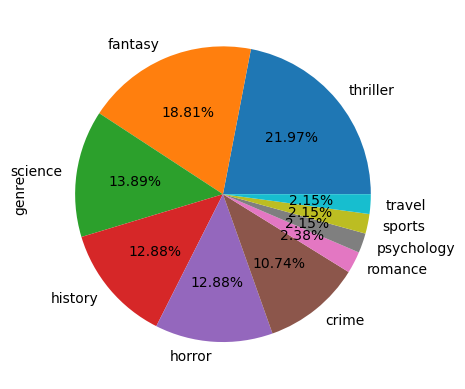

In [7]:
df["genre"].value_counts().plot(kind="pie", autopct="%.2f%%")
print("Hay un total de {:.2f} géneros literarios diferentes:".format(len(df["genre"].value_counts())))
for i in df["genre"].unique():
    print(i)

Parece ser que no es un dataset balanceado (existe un desequilibrio entre las distintas clases de la variable género), lo cual puede que llegue a comprometer el rendimiento del modelo. Vamos a hacer diferentes wordclouds con varios de los géneros recogidos. Un wordcloud o nube de palabras es una representación visual de un conjunto de palabras en la que el tamaño de cada palabra está relacionado con su frecuencia o importancia en un texto o conjunto de datos. Las palabras más frecuentes o relevantes aparecen con mayor tamaño y resaltadas.

In [8]:
def print_wordCloud(genero, resumen):   #definimos la función que construirá el gráfico wordcloud
    # mostramos a que género corresponde la visualización que se construirá
    print(genero)
    
    # creamos una instancia de wordcloud con
    wordcloud = WordCloud(width=400, height=400, background_color='white', min_font_size=10).generate(resumen)
    
    # configurar la figura de matplotlib
    plt.figure(figsize=(5, 5), facecolor='white', edgecolor='blue')
    
    # mostrar el wordcloud 
    plt.imshow(wordcloud)
    
    # configurar opciones de visualización
    plt.axis("off")
    plt.tight_layout(pad=0)
    
    # mostrar el gráfico del wordcloud
    plt.show()

def make_string(genre):   #definimos la funcion que recopilara todas las palabras utilizadas en los resumenes de determinado genero

    s = "" #cadena vacía para almacenar palabras
    
    for row_index, row in df.iterrows():  #recorremos las filas del dataset
        if row['genre'] == genre: #comprobamos que extraemos el resumen del genero deseado
            s += (row['summary'] + ' ') #almacenamos el resumen en la cadena s

    return s

fantasy


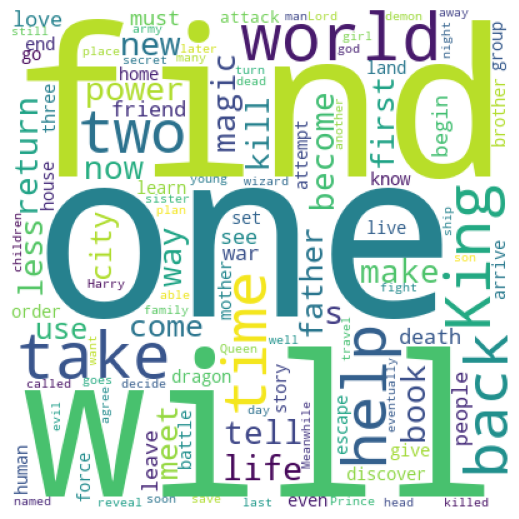

science


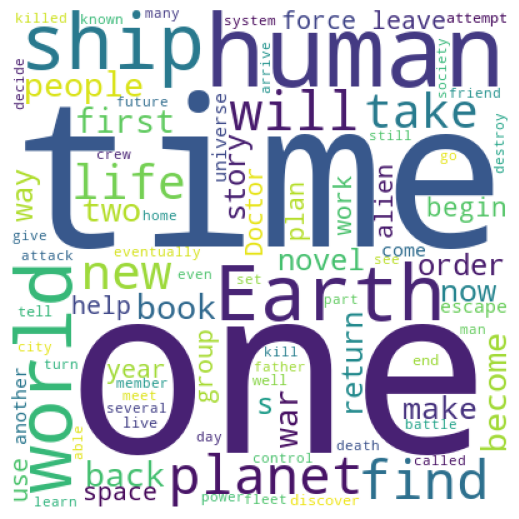

crime


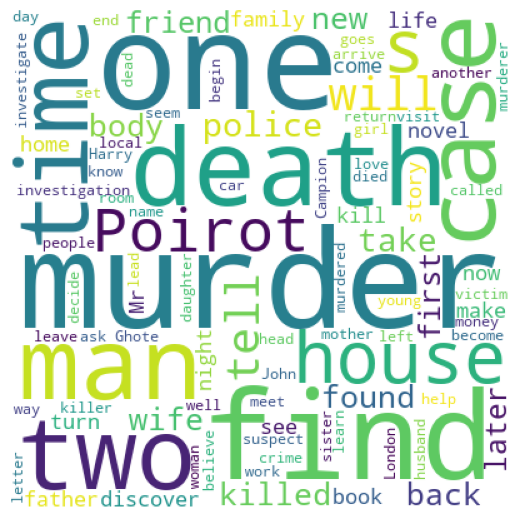

history


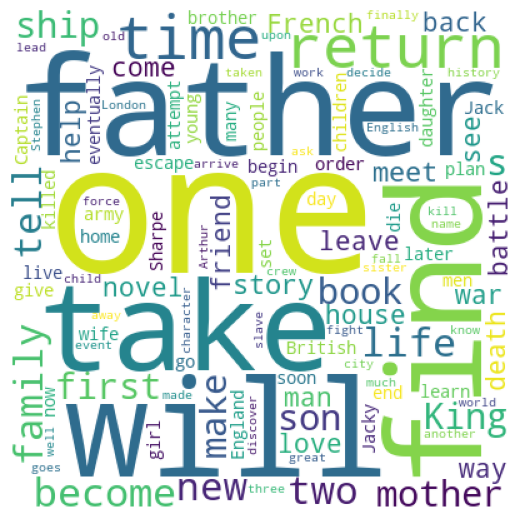

horror


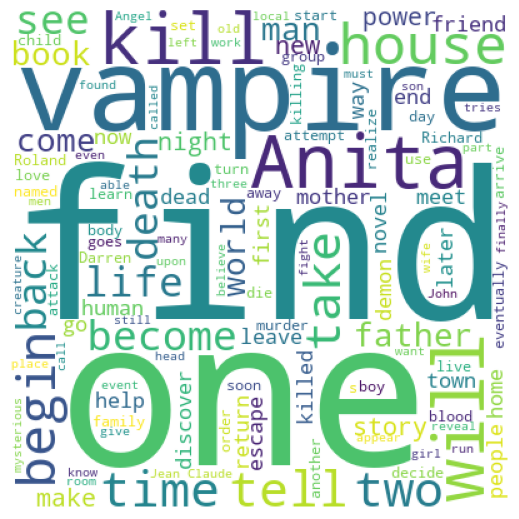

thriller


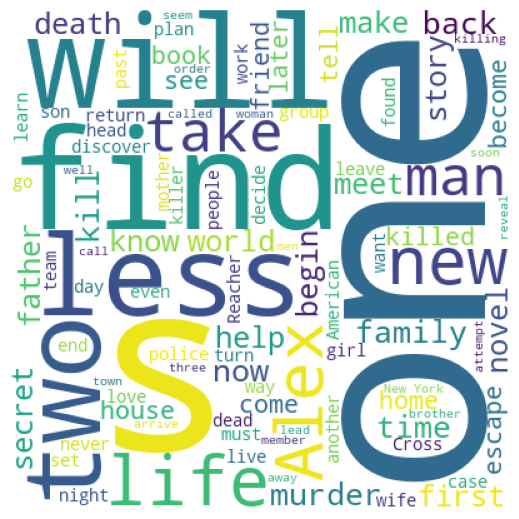

psychology


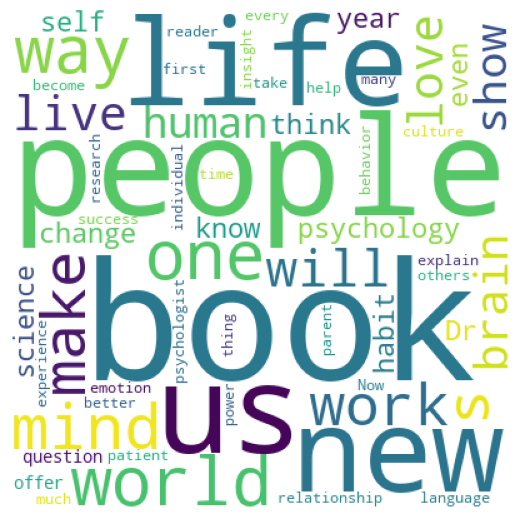

romance


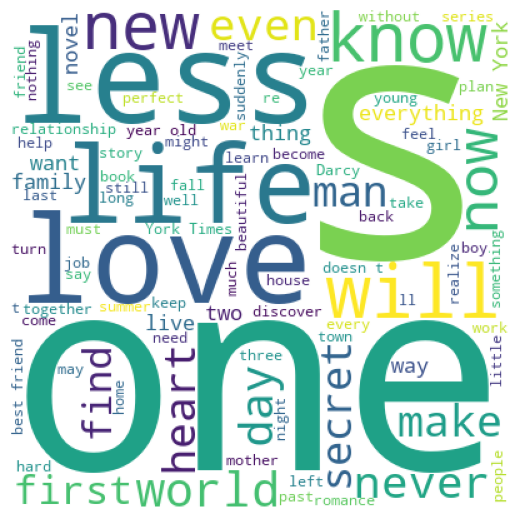

sports


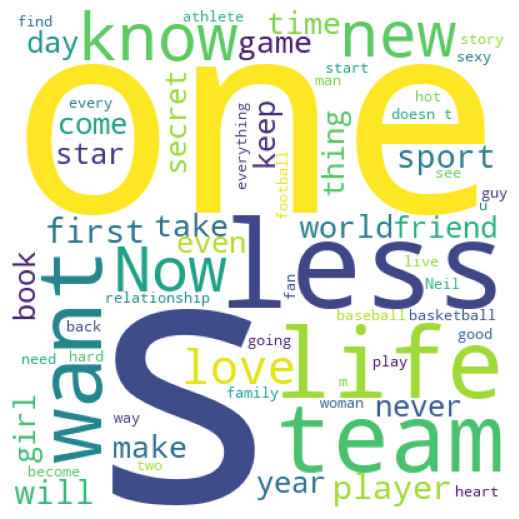

travel


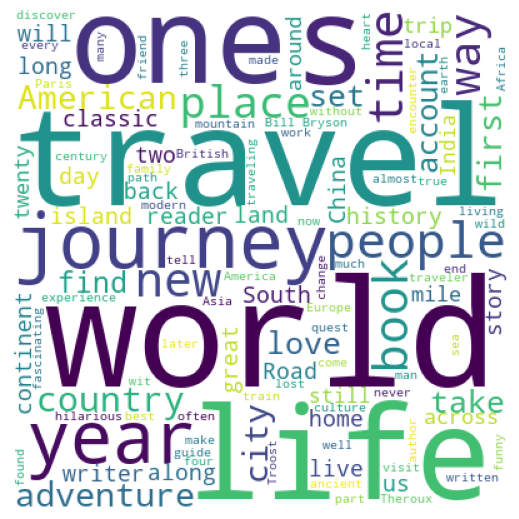

In [9]:
genre = df['genre'].unique().tolist() #obtenemos una lista de los generos

# iteramos sobre los géneros
for Genre in genre:
    summary = make_string(Genre) #obtemeos todas las palabras distintas utilizadas en cada genero
    print_wordCloud(Genre, summary) #generamos el wordcloyud    

A primera vista, llama la atención que diversas palabras se repiten practicamente para todos los géneros, como one o find. Esto será tratado en el preprocesamiento de los datos. Vamos a ver cuales son las palabras que más se repiten en general entre todos los resúmenes recopilados:

In [10]:
summary_text = ' '.join(df['summary'].values) #hacemos un solo string con todos los resumenes

tokens = word_tokenize(summary_text)  #tokenizamos

#hacemos un pequeño preprocesamiento para obtener información más relevante en la gráfica

tokens = [word.lower() for word in tokens if word not in string.punctuation] #filtramos signos de puntuacion y pasamos a minusculas

stop_words = set(stopwords.words('english'))  #cargamos stopwords
tokens = [word for word in tokens if word not in stop_words] #fittramos stopwords

# contamos palabras y seleccionamos las 50 más comunes
word_freq = nltk.FreqDist(tokens)
top_words = word_freq.most_common(50)

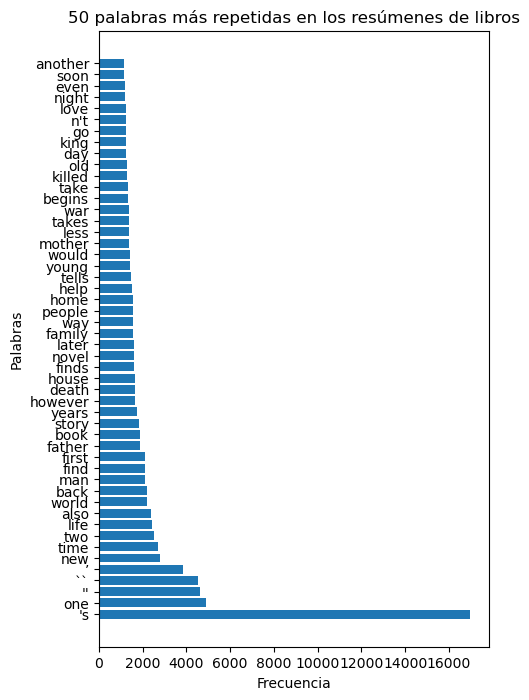

In [11]:
words, freqs = zip(*top_words)
fig, ax = plt.subplots(figsize=(6, 8))  # Ajusta el tamaño del gráfico según tus necesidades
ax.barh(words, freqs)
ax.set_xlabel('Frecuencia')
ax.set_ylabel('Palabras')
ax.set_title('50 palabras más repetidas en los resúmenes de libros')
plt.subplots_adjust(left=0.25)  # ajuste del margen izquierdo para ver que palabras se estan representando
plt.show()

Se aprecia la necesidad de un buen preprocesamiento del texto, dado que los caracteres más repetidos son irrelevantes, como ´s, " o '. Procedemos en el siguiente apartado con la limpieza y depuración de los textos recopilados

### 4. Preprocesamiento de los datos

Vamos a aplicar dos sencillas técnicas de NLP para el problema que nos acontece, Bag of Words (BoW) y TF-IDF (Term Frequency-Inverse Document Frequency). Antes de explicarlas y aplicarlas, tenemos que realizar un preprocesamiento de los datos para poder aplicar estas técnicas de manera eficaz. Así, procedemos a realizar las siguientes acciones para preprocesar el texto: 

1. Quitar nombres propios
2. Pasar todo a minúsculas
3. Eliminar signos de puntuación y elementos que no sean palabras
4. Eliminar stopwords (palabras comunes y frecuentes en un idioma determinado que se consideran de poco valor semántico para el análisis de texto)

Se define a continuación la función que aplicará este preprocesado:

In [12]:
def eliminar_nombres_propios(texto):
    toks = nltk.word_tokenize(texto)
    tagged_toks = nltk.pos_tag(toks)  # Etiquetar los tokens con POS tags
    toks = [tok for tok, pos in tagged_toks if pos != 'NNP']
    texto = " ".join(toks)
  
    return texto

In [13]:
def preprocesar_texto(texto):
    texto= eliminar_nombres_propios(texto)
    stop_words_list = stopwords.words("english") # cargamos las stopwords en una variable
    texto = texto.lower()  # pasar a minúsculas
    texto = texto.translate(str.maketrans("", "", string.punctuation)) # quitar signos de puntuación
    toks = nltk.word_tokenize(texto) # tokenizamos
    toks = [tok for tok in toks if tok not in stop_words_list and not tok.isdigit()] # quitamos stopwords y números
    toks = [tok.strip() for tok in toks if len(tok.strip()) > 1] # quitamos espacios sobrantes que hayan podido quedar
    texto = " ".join(toks) # juntamos los tokens procesados en una sola cadena
  
    return texto

In [14]:
df["summary"] = df["summary"].apply(preprocesar_texto)

Limpieza hecha, procedemos a aplicar unas técnicas un poco más complejas para hacer más eficaz este preprocesamiento:

1. Lematización: Consiste en reducir las palabras a su lema o forma base. El lema es la forma canónica de una palabra, es decir, la forma en el diccionario. 
2. Stemming: De manera más sencilla, esta técnica busca reducir las palabras a su raíz mediante la eliminación de sufijos y/o prefijos

In [15]:
lemmatizer = WordNetLemmatizer()

def lemmatizing(text):
    stemmed_text = "" #cadena vacia para guardar el texto procesado
    for word in text.split():  #iteracion sobre el texto aportado
        stem = lemmatizer.lemmatize(word) #lematizacion 
        stemmed_text += stem #se añade la palabra lematizada a la nueva cadena
        stemmed_text += " " # y también un espacion en blanco
        
    stemmed_text = stemmed_text.strip() #se eliminan espacios sobrantes y se 
    return stemmed_text                 #devuelve el texto lematizado

In [16]:
df["summary"] = df["summary"].apply(lemmatizing)   #aplicamos la lematizacion sobre los resumenes

In [17]:
stemmer = PorterStemmer()
def stemming(text):
    stemmed_text = ""  #cadena vacia para guardar el texto procesado
    for word in text.split():  #iteracion sobre el texto aportado
        stem = stemmer.stem(word) #stemizacion
        stemmed_text += stem 
        stemmed_text += " "
        
    stemmed_text = stemmed_text.strip()
    return stemmed_text

In [18]:
df["summary"] = df["summary"].apply(stemming) #aplicamos la lematizacion sobre los resumenes

Para el momento de aplicar los modelos que desarrollemos sobre la variable objetivo, conviene que realicemos One Hot Encoding sobre esta. Esta técnica consiste en crear una nueva columna binaria para cada categoría única en la variable original, donde cada columna indica la presencia o ausencia de esa categoría en una instancia específica. Esto resulta conveniente para cuando el modelado se realice sobre redes neuronales.

Vamos a hacer OneHotEncoding:

In [19]:
clases= ['fantasy', 'science', 'crime', 'history', 'horror', 'thriller', 'psychology', 'romance', 'sports', 'travel']

encoder= OneHotEncoder(categories=[clases]) #inicializamos la clase OneHotEncoder

categorias_encoded = encoder.fit_transform(df.genre.to_numpy().reshape(-1,1)).toarray() #transformamos los datos

y_onehot= pd.DataFrame(categorias_encoded, columns= clases) #obtenemos un data frame con las nuevas variables

In [20]:
y_onehot.head()

,fantasy,science,crime,history,horror,thriller,psychology,romance,sports,travel
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df= pd.concat([df,y_onehot],axis=1)  #agregamos nuestras variables generadas al dataset

Como se ha mencionado antes, aplicaremos dos técnicas distintas para ver que cual se comporta mejor con cada modelo. Vamos con BoW. Bag of Words sirve para representar un texto como un conjunto desordenado de palabras. Se basa en el supuesto de que el orden de las palabras en un documento no es relevante y que solo la frecuencia de aparición de las palabras importa. Así, con está técnica vamos a realizar un muestreo de la cantidad de veces que aparece cierta palabra en cada resumen.

In [22]:
num_palabras= 4000 #seleccionamos el número máximo de palabras que muestrearemos. Esta variable servirá también para Tf-Idf

In [23]:
vectorizador_bow = CountVectorizer(max_features=num_palabras) #inicializamos la clase indicando el número maximo de palabras que 
#muestreamos. Estas serán las mas frecuentes en todo el corpus construido

vectorizado_bow = vectorizador_bow.fit_transform(df.summary).toarray() #transformamos la variable de resumenes

palabras = vectorizador_bow.get_feature_names_out() #los nombres de las variables generadas corresponden a cada palbra muestreada

X_bow= pd.DataFrame(vectorizado_bow, columns=palabras)

In [24]:
X_bow.head()

,1950,1970,1980,20th,abandon,abbey,abduct,abil,abl,aboard,...,yellow,yet,yield,young,younger,youngest,youth,zombi,zone,zoo
0,0,0,0,0,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


Vamos con Tf-idf. Esta proporciona una representación numérica de la importancia de un término en un documento en relación con un corpus más grande. La fórmula que determina el valor correspondiente es:

TF-IDF = TF (Frecuencia del término) * IDF (Frecuencia inversa del documento)

In [25]:
vectorizador_tf = TfidfVectorizer(max_features=num_palabras)

vectorizado_tf = vectorizador_tf.fit_transform(df.summary).toarray() #transformamos la variable de resumenes

palabras = vectorizador_tf.get_feature_names_out()

X_tf= pd.DataFrame(vectorizado_tf, columns=palabras)

In [26]:
X_tf.head()

,1950,1970,1980,20th,abandon,abbey,abduct,abil,abl,aboard,...,yellow,yet,yield,young,younger,youngest,youth,zombi,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081288,0.057371,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.086299,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028340,0.000000,...,0.055136,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Se han aplicado ya unas cuantas técnicas de preprocesamiento de datos. Esto casi siempre es más importante que los algoritmos utilizados para el modelo y aprendizaje a la hora de obtener buenos resultados. Voy a tratar de refinar un poco más. Dado el gran número de variables obtenidas para la realización de predicciones, voy a aplicar LSA, de manera que cuando entrenemos los modelos podamos evaluar la precision obtenida con LSA y sin ella.

LSA (Latent Semantic Analysis) es una técnica de reducción de dimensionalidad que se utiliza en NLP para descubrir patrones semánticos en datos de texto. La ventaja de LSA es que puede capturar relaciones semánticas y descubrir patrones ocultos en los datos textuales. Además, la reducción de dimensionalidad ayuda a eliminar ruido y redundancia, lo que puede mejorar el rendimiento del clasificador.

In [27]:
lsa = TruncatedSVD(n_components= int(num_palabras/4)) #cargamos el modelo con el maximo numero de componentes deseadas
X_bow_lsa = lsa.fit_transform(X_bow)
X_tf_lsa= lsa.fit_transform(X_tf)

Con todos los distintos datos procesados obtenidos, cargamos los las distintas variables de entrenamiento y testeo de cara a proceder al entrenamiento de modelos. Cabe destacar que train_test_split se ocupa de dividir los datos de manera desordenada y en este caso estratificada, para que tanto los conjuntos de entrenamiento como los de testeo sean igual de representativos para cada una de las clases representadas:

In [28]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, df.genre, test_size=0.2, stratify= df.genre, random_state=2)

X_train_tf, X_test_tf, y_train, y_test = train_test_split(X_tf, df.genre, test_size=0.2, stratify= df.genre,random_state=2)

X_train_bow_lsa, X_test_bow_lsa, y_train, y_test = train_test_split(X_bow_lsa, df.genre, test_size=0.2, stratify= df.genre,random_state=2)

X_train_tf_lsa, X_test_tf_lsa, y_train, y_test = train_test_split(X_tf_lsa, df.genre, test_size=0.2, stratify= df.genre,random_state=2)

### 4 Entrenamiento y evaluación de modelos

Vamos a contruir diferentes modelos para ver cual se puede adaptar mejor a la solución del problema planteado. En total vamos a probar 3 en total:

1. Regresión logística
2. Random Forest
3. Redes Neuronales

#### 4.1 Regresión logística

La regresión logística es un algoritmo de aprendizaje supervisado utilizado para la clasificación de datos. A diferencia de la regresión lineal, que se utiliza para predecir valores numéricos continuos, la regresión logística se utiliza para predecir la probabilidad de que un ejemplo pertenezca a una determinada clase.

Construimos un modelo para cada uno de los preprocesamientos que queremos probar:

In [29]:
# Modelo 1: X_train_bow y X_test_bow
model1 = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=3000)
model1.fit(X_train_bow, y_train)
y_pred1 = model1.predict(X_test_bow)
accuracy1 = accuracy_score(y_test, y_pred1)
print("Precisión del modelo 1: {:.2f}%".format(accuracy1 * 100))

Precisión del modelo 1: 60.30%


In [30]:
# Modelo 2: X_train_tf y X_test_tf
model2 = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=3000)
model2.fit(X_train_tf, y_train)
y_pred2 = model2.predict(X_test_tf)
accuracy2 = accuracy_score(y_test, y_pred2)
print("Precisión del modelo 2: {:.2f}%".format(accuracy2 * 100))

Precisión del modelo 2: 63.73%


In [31]:
# Modelo 3: X_train_bow_lsa y X_test_bow_lsa
model3 = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=3000)
model3.fit(X_train_bow_lsa, y_train)
y_pred3 = model3.predict(X_test_bow_lsa)
accuracy3 = accuracy_score(y_test, y_pred3)
print("Precisión del modelo 3: {:.2f}%".format(accuracy3 * 100))

Precisión del modelo 3: 57.94%


In [32]:
# Modelo 4: X_train_tf_lsa y X_test_tf_lsa
model4 = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=3000)
model4.fit(X_train_tf_lsa, y_train)
y_pred4 = model4.predict(X_test_tf_lsa)
accuracy4 = accuracy_score(y_test, y_pred4)
print("Precisión del modelo 4: {:.2f}%".format(accuracy4 * 100))

Precisión del modelo 4: 64.27%


El solver seleccionado ha sido saga dada su efectividad ante grandes conjuntos de datos. En este caso, el mejor rendimiento del modelo lo obtenemos cuando el preprocesado consiste en Tf-Idf+ LSA. Lo podemos representar graficamente para comparar los rendimientos obtenidos:

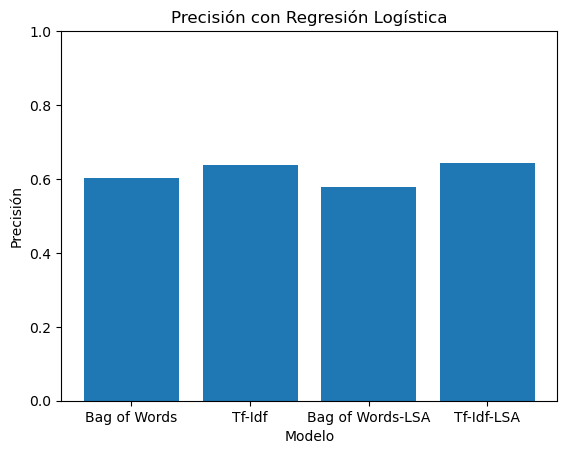

In [33]:
# Precisión de cada modelo
accuracies = [accuracy1, accuracy2, accuracy3, accuracy4]

# Etiquetas de los modelos
model_labels = ["Bag of Words", "Tf-Idf", "Bag of Words-LSA", "Tf-Idf-LSA"]

# Gráfico de barras
plt.bar(model_labels, accuracies)
plt.xlabel("Modelo")
plt.ylabel("Precisión")
plt.title("Precisión con Regresión Logística")
plt.ylim(0, 1)  # Ajustar los límites del eje y si es necesario
plt.show()

#### 4.2 Random forest

Random Forest es un algoritmo de aprendizaje automático que combina múltiples árboles de decisión entrenados en muestras aleatorias del conjunto de datos. Cada árbol se construye dividiendo los datos en base a características aleatorias, y las predicciones individuales de cada árbol se combinan mediante votación o promedio para obtener una predicción final. Random Forest es conocido por su capacidad para manejar grandes conjuntos de datos, lidiar con valores faltantes y características categóricas, y su resistencia al sobreajuste. Es una herramienta poderosa y versátil utilizada tanto en problemas de clasificación como de regresión.

Igual que antes, construimos un modelo para cada preprocesamiento:

In [34]:
# Modelo 1: X_train_bow y X_test_bow
model1 =  RandomForestClassifier(n_estimators=100)
model1.fit(X_train_bow, y_train)
y_pred1 = model1.predict(X_test_bow)
accuracy1 = accuracy_score(y_test, y_pred1)
print("Precisión del modelo 1: {:.2f}%".format(accuracy1 * 100))

Precisión del modelo 1: 58.69%


In [35]:
# Modelo 2: X_train_tf y X_test_tf
model2 =  RandomForestClassifier(n_estimators=100)
model2.fit(X_train_tf, y_train)
y_pred2 = model2.predict(X_test_tf)
accuracy2 = accuracy_score(y_test, y_pred2)
print("Precisión del modelo 2: {:.2f}%".format(accuracy2 * 100))

Precisión del modelo 2: 58.91%


In [36]:
# Modelo 3: X_train_bow_lsa y X_test_bow_lsa
model3 =  RandomForestClassifier(n_estimators=100)
model3.fit(X_train_bow_lsa, y_train)
y_pred3 = model3.predict(X_test_bow_lsa)
accuracy3 = accuracy_score(y_test, y_pred3)
print("Precisión del modelo 3: {:.2f}%".format(accuracy3 * 100))

Precisión del modelo 3: 39.91%


In [37]:
# Modelo 1: X_train_tf_lsa y X_test_tf_lsa
model4 =  RandomForestClassifier(n_estimators=100)
model4.fit(X_train_tf_lsa, y_train)
y_pred4 = model4.predict(X_test_tf_lsa)
accuracy4 = accuracy_score(y_test, y_pred4)
print("Precisión del modelo 4: {:.2f}%".format(accuracy4 * 100))

Precisión del modelo 4: 50.00%


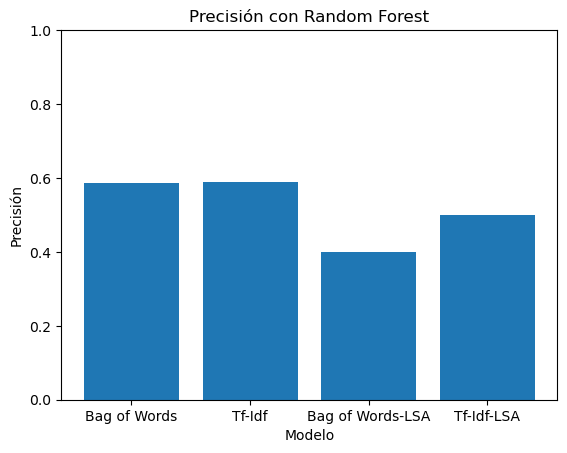

In [38]:
# Precisión de cada modelo
accuracies = [accuracy1, accuracy2, accuracy3, accuracy4]

# Etiquetas de los modelos
model_labels = ["Bag of Words", "Tf-Idf", "Bag of Words-LSA", "Tf-Idf-LSA"]

# Gráfico de barras
plt.bar(model_labels, accuracies)
plt.xlabel("Modelo")
plt.ylabel("Precisión")
plt.title("Precisión con Random Forest")
plt.ylim(0, 1)  # Ajustar los límites del eje y si es necesario
plt.show()

Random Forest admite probar más hiperparámetros que la regresión logística. Sin embargo, no haré Grid Search (búsqueda de hiperparámetros) dado que parece que viendi el rendimiento del algoritmo de regresión logística parece que es un modelo más adeucuado para este problema que Random Forest.

#### 4.3 Redes neuronales 

Vamos con las redes neuronales. Es probable que este algoritmo no sea el más adecuado en este contexto dada la complejidad del modelo para el enfoque sencillo que se le esta dando al problema, pero por probar no pasa nada, a ver si conseguimos mejorar los resultados obtenidos por el regresor logístico

In [39]:
seed = 42   
torch.manual_seed(seed)  
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)    #introducimos semillas aleatorias

Dividimos los sets de train y de test, esta vez utilizando la variable objetivo genre en formato OneHot. En el caso de los datos preprocesados que elegimos para probar con nuestra red, me quedo con Tf-Idf dados los buenos resultados obtenidos en los dos modelos previos

In [40]:
X_train, X_test, y_train_onehot, y_test_onehot = train_test_split(X_tf.values, y_onehot, test_size=0.2, stratify= y_onehot, random_state=3)

Pytorch, librería utilizada para la programación de estas redes neuronales, requiere de tensores para realizar los calculos necesarios, por lo que creamos nuevas variables

In [41]:
tX_train = torch.tensor(X_train, requires_grad=False, dtype=torch.float)
tX_test = torch.tensor(X_test, requires_grad=False, dtype=torch.float)
ty_train = torch.tensor(y_train_onehot.values, requires_grad=False, dtype=torch.float)  
ty_test = torch.tensor(y_test_onehot.values, requires_grad=False, dtype=torch.float)  

Construimos la red neuronal. En este caso, se trata de una red neuronal de múltiples capas, la cual se utiliza bastante en probelmas de clasificación para extraer patrones complejos gracias a las capas ocultas. A parte de las capas y las funciones activación tipicas, vamos a añadir capas de dropout para evitar el sobrenetrenamiento tan fácil de provocar en las redes neuronales. El dropout es una técnica que aleatoriamente apaga un porcentaje de las neuronas en cada paso de entrenamiento. Esto ayuda a prevenir la coadaptación de las neuronas y reduce la dependencia entre ellas, lo que a su vez reduce el riesgo de sobreajuste.

In [42]:
class LinearNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.7)  # Capa de dropout 1
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.6)  # Capa de dropout 2
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)  # Capa de dropout 3
        self.fc4 = nn.Linear(hidden_size_3, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.dropout3(out)
        out = self.fc4(out)
        out = self.softmax(out)
        return out

Inicializamos el modelo y hacemos un forward pass para probar si todo esta correcto. También seleccionamos el tamaño de las capas ocultas específicas a utilizar:

In [43]:
input_size = num_palabras  #la capa de entrada tendra el tamaño del numero de features que hayamos obtenido tras el preprocesado
hidden_size_1 = 500  
hidden_size_2 = 100
hidden_size_3=50
output_size = 10  


nn = LinearNet(input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size) #inicializamos la red con los tamaños seleccionados

In [44]:
nn(tX_train[0:1])  #forward pass

tensor([[0.0978, 0.0940, 0.1095, 0.0944, 0.1102, 0.0913, 0.0874, 0.1036, 0.1024,
         0.1092]], grad_fn=<SoftmaxBackward0>)

Inicializamos los pesos de la red mediante la inicialización Xavier, la cual facilitará el entrenamiento de la misma:

In [45]:
def init_f(forw):   #definimos la funcion que permitirá realizar la inicializacion Xavier
    for nam, param in forw.named_parameters():  #recorremos los parametros de la red
        if 'weight' in nam:
            torch.nn.init.xavier_normal_(param) 
        else:
            param.data.fill_(0.01)

Preparamos una función que permita calcuar el loss:

In [46]:
def loss_f(x, y, forw):
    return torch.nn.functional.cross_entropy(forw(x), y)

Preparamos una funcion para calcular el score de nuestra red:

In [47]:
def score_f(x, y, forw):
    with torch.no_grad():
        y_pred = forw(x)  
        y_pred_labels = torch.argmax(y_pred, dim=1) 
        y_true_labels = torch.argmax(y, dim=1)  
        score = torch.sum(y_pred_labels == y_true_labels).item() / len(y)
    return score

Vamos a utilizar un optimizador con nuestra red, el cual permita facilitar el proceso de entrenamiento:

In [48]:
opt = torch.optim.Adam(nn.parameters(), lr=0.0005)

Preapramos una funcion para entrenar al modelo:

In [49]:
def t_step(x, y, forw, opt):
    opt.zero_grad() # reseteamos los valores acumulados de las derivadas
    loss = loss_f(x, y, forw) # calculamos la 'loss' con los resultados 
    out = loss.item() # almacenamos nuestro valor de loss para devolverlo como resultado intermedio
    loss.backward() # propagamos las derivadas de la 'loss' con respecto a nuestros parámetros
    opt.step() # ejecutamos un paso de nuestro optimizador
    return out

In [50]:
init_f(nn)  #inicializamos la red antes de proceder al entrenamiento

In [51]:
for i in range(100):
    out = t_step(tX_train, ty_train, nn, opt)
    if i%10 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(i, out))

Epoch: 0, Loss: 2.3032
Epoch: 10, Loss: 2.2890
Epoch: 20, Loss: 2.2615
Epoch: 30, Loss: 2.2267
Epoch: 40, Loss: 2.1905
Epoch: 50, Loss: 2.1361
Epoch: 60, Loss: 2.0750
Epoch: 70, Loss: 2.0283
Epoch: 80, Loss: 1.9803
Epoch: 90, Loss: 1.9430


In [52]:
print(score_f(tX_train, ty_train, nn))
print(score_f(tX_test, ty_test, nn))

0.5836241610738255
0.4613733905579399


El modelo queda muy sobrenetrenado, dada la significativa diferencia entre el score de train y el de test. Dado que las pruebas sobre el set de testeo no dan mejores resultados que los otros modelos, descartaremos la red neuronal como modelo final a seleccionar

### 5. Selección de modelo y prueba

Dado el buen rendimiento obtenido, el modelo con el que nos quedamos será la regresión logística multilineal con preprocesado Tf-Idf y LSA. Vamos a tratar de disponer de el en las siguientes lineas de codigo, a comprobar que no está sobreentrenado y a tratar de hacer predicciones con resumenes de libros ajenos al dataset para comprobar que funciona eficazmente.

In [53]:
# Modelo Def: Tf-Idf y LSA
model_def = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=3000)
model_def.fit(X_train_tf_lsa, y_train)
y_pred_def = model_def.predict(X_test_tf_lsa)
accuracy_def = accuracy_score(y_test, y_pred_def)
print("Precisión del modelo 4: {:.2f}%".format(accuracy_def * 100))

Precisión del modelo 4: 64.27%


Vamos a verificar que el modelo no esté sobrenetrenado con validación cruzada, la cual consiste en coger, en este caso concreto 10 partes del dataset y evaluar la precisión del modelo con cada uno de eso subconjuntos. Finalmente se realiza la media, si esta es mucho menor que la precisión del modelo obtenida previamente, se considera que existe sobreenetrenamiento

In [54]:
# realizar la validación cruzada con 10 folds
scores = cross_val_score(model_def, X_train_tf_lsa, y_train, cv=10, scoring='accuracy')

# calcular la precisión promedio
average_accuracy = scores.mean()

# mostrar la precisión promedio
print("Precisión promedio: {:.2f}%".format(average_accuracy * 100))

Precisión promedio: 65.37%


In [55]:
print(scores)

[0.67828418 0.64879357 0.64879357 0.69705094 0.65683646 0.58870968
 0.63172043 0.68010753 0.64784946 0.65860215]


El modelo parece que no presenta sobreentrenamiento, por lo tanto procedemos a darlo como válido. Vamos a crear una funcion para poder realizar predicciones facilmente y probar el modelo con datos ajenos al dataset.

In [56]:
def hacer_prediccion(titulo,x):
    x= preprocesar_texto(x)
    x= lemmatizing(x)
    x= stemming(x)
    x_tf = vectorizador_tf.transform([x]).toarray() 
    x_tf_lsa = lsa.transform(x_tf)
    pred= model_def.predict(x_tf_lsa)
    
    return "El género de " + titulo + " debe de ser: "+ pred[0]

Vamos a predecir el genero de tres libros diferentes, los cuales me he cerciorado que no están presentes en el dataset:

1. La Biblioteca de Medianoche -  Matt Haig: Un thirller acerca de las posibles vidas que la protagonista podría haber vivido, las cuales va descubriendo a través de los libros que se encuentran en una biblioteca en la que se despierta tras intentar suicidarse. La novela, a parte de thirller, tiene su punto de fantasía y ciencia a ficcion, por lo que será interesante para poner a prueba al clasificador
2. Inteligencia Emocional- Daniel Goleman: Best Seller de psicología, habla de la teoría del autor acerca de las competencias emocionales intrapersonales y extrapersonales en los seres humanos
3. El misterio de la cripta embrujada- Eduardo Mendoza: Novela de humor pero sobretodo policiaca, vamos a probar a traducir el resumen de esta novela española con el traductor a ver si la clasifica correctamente como novela policiaca

In [57]:
df.loc[df['title'] == "The Midnight Library"] #ejemplo de búsqueda de los titulos seleccionados

,title,genre,summary,fantasy,science,crime,history,horror,thriller,psychology,romance,sports,travel


In [58]:
resumen_1= "Nora Seed, a 36-year-old music store clerk, is struggling to cope with overwhelming regret about the state of her life. In a period of just over a day, Nora’s cat dies, she loses her job at the music store, she has a confrontational run-in with her former bandmate, and she loses her lone piano student. Her brother Joe is avoiding her, her best friend Izzy isn’t responding to her text messages, and even her next-door neighbor, old Mr. Banerjee, says he doesn’t need Nora to help him with his medications anymore. Her parents have passed away, her father when she was a teenager, and her mother just a few years ago. After her mother’s death, Nora left her ex-fiancé, Dan, just two days before they were supposed to be married. Nora surveys her life and sees only pain, grief, and regret. She decides that she has nothing left to live for. She leaves a note, makes a final post on social media, and attempts to kill herself."

In [59]:
resumen_2= "Emotional Intelligence, written by Daniel Goleman, is a book that explores the significance of emotional intelligence in our lives and its impact on personal and professional success. The author argues that emotional intelligence is a crucial skill that allows us to understand and manage our emotions, as well as those of others.In the book, Goleman presents scientific research supporting the idea that emotional intelligence is a key factor in effective leadership, healthy interpersonal relationships, and overall well-being. He emphasizes the importance of developing skills such as self-control, empathy, self-motivation, and the ability to manage social relationships.Goleman delves into various aspects of emotional intelligence, including emotional awareness, emotional self-regulation, motivation, empathy, and social skills. Additionally, he provides practical examples and advice for enhancing our emotional intelligence in different areas of our lives."

In [60]:
resumen_3= "Commissioner Flores is an inspector from the Criminal Investigation Brigade. Faced with the case of a missing girl from a boarding school run by the Lazarist mothers, the inspector decides to seek help from a former depraved criminal who is confined in a mental institution. They strike a deal: if he helps solve the case, he will earn his freedom. After releasing the inmate from the mental institution, he returns to Barcelona after 5 years of confinement. Although he has regained control of himself, he still possesses his old instinct that allows him to create false identities, impersonate others, or open doors without keys. He reunites with his sister and becomes involved in a story where a wealthy Catalan industrialist wants to hide a dead body. In an attempt to cover up this death, various crimes (murders, drugs, etc.) occur, which the former inmate manages to solve with the help of a former student from the school, Mercedes."

In [61]:
hacer_prediccion('La Biblioteca de Medianoche',resumen_1)

'El género de La Biblioteca de Medianoche debe de ser: thriller'

In [62]:
hacer_prediccion('Inteligencia Emocional',resumen_2)

'El género de Inteligencia Emocional debe de ser: psychology'

In [63]:
hacer_prediccion('El misterio de la cripta embrujada', resumen_3)

'El género de El misterio de la cripta embrujada debe de ser: crime'

### 6. Conclusiones

Hemos logrado un modelo de clasificación capaz de identificar a qué género literario pertenece un libro en función de su resumen, con un porcentaje de acierto del 64%. Esta cifra podría parecer subestimable, pero es importante recalcar que la clasificación se está realizando entre 10 clases distintas (ciencia, fantasía, horror, thriller...). En problemas de clasificación binaria, la precisión de los modelos suele rondar el 80% (sin sobreentrenar), pero estos solo distinguen entre la pertenencia a una clase o no. Por tanto se puede considerar que nuestro modelo es eficaz, habiendo tenido resultados muy satisfactorios para las pruebas con resumenes de libros ajenos al dataset.

El problema seleccionado puede parecer irrelevante para su exportación y puesta en producción, sin embargo no puedo estar más en desacuerdo. Si bien las novelas más populares que salen al mercado no requieren de ninguna clasificación a priori (ya hay publicistas y editores encargados de venderla y moverla de acuerdo con las etiquetas que consideren oportunas), existen otras aplicaciones donde los escritores son más independientes, como Wattpad o Inskpired, plataformas donde se publican escritos propios sin editar, en la que modelos de este tipo pueden facilitar la clasificación de los escritos y actuar sinérgicamente con sistemas de recomendación que mejoren la experiencia de usuario.

Cabe destacar que con mayores recursos en cuanto a cantidad de datos y capacidad de computación se refiere, este clasificador por resumenes podría evolucionar a un clasificador a partir del análisis de libros enteros, siendo todavía más razonable su implicación en aplicaciones como las mencionadas previamente.

Para finalizar, recojo algunas ideas que podrían dar lugar a un modelo más interesante en versión 2.0:

1. Incrementar el rendimiento contando con más datos: Como en cualquier tipo de problema de machine learning, resultan más importantes los datos con los que se trabaje que el modelo que se escoja para, en este caso, clasificarlos. Con un mayor volumen de datos se podría mejorar el rendimiento del modelo, así como, clasificando previamente estos datos y ampliandolos de manera adecuada, identificar más géneros que no están reflejados en este dataset (aventuras, humor, infantil, novela filosófica...)
2. Ampliar las posibilidades de clasificación: Dado que los libros generalmente abarcan más de un género (tenemos por ejemplo la novela de Eduardo Mendoza utilizada para la prueba del modelo en el anterior apartado, una novela policiaca y de humor a la vez), avanzar hacia un modelo que etiquete las novelas con más de un género resultaría muy interesante
3. Crear modelos entrenados en otros idiomas: Este modelo esta entrenado para procesar textos en inglés, pero con los datos necesarios se podrían crear modelos específicos para otros idiomas
4. Realizar clasificación de libros enteros en lugar de resúmenes: Con una mayor cantidad de recursos, como se ha expuesto previamente, se podría generalizar el modelo para la clasificación del género de libros enteros, lo que supondría un escalado importante del problema a resolver, dada la variabilidad de los datos con los que se trabajaría, así como su ocupación de memoria y la consiguiente capacidad de procesarlos
